In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import import_ipynb
import hall_data
import SESnaps_data
import SE_batch_data
import numpy as np
from astropy import units as u
from astropy import constants as const

importing Jupyter notebook from hall_data.ipynb
importing Jupyter notebook from SESnaps_data.ipynb
importing Jupyter notebook from SE_batch_data.ipynb


In [2]:
hall = hall_data.get_df()
se   = SESnaps_data.df

In [3]:
idf = hall.merge(se, how='outer',
               on = ['doping', 'capping', 'anneal'])

In [4]:
my_units = {
    'mu' : u.m**2/(u.V*u.s),
    'm_star' : u.M_e,
    'L_Debye': u.nm,
    'omega' : u.V*const.e.si/const.hbar,
    'N_e' : u.m**-3
}

In [5]:
LOGGING = True

def show_units(df, prefix = ''):
    for column in df.columns:
        try:
            print(prefix + column, ' : ', df[column].values.unit.decompose())
        except:
            pass
    return df

def functional(fn):
    def wrapped(df):
        return fn(df.copy(deep=True))
    return wrapped

LOGGING = True

def logging_true(after = True, before = False):
    def logger(fn):
        def wrapper(df):
            print(f'===== applying {fn.__name__} =====')
            if before:
                print(">>> Before")
                show_units(df, prefix = " - ")
                print('')
            try:    
                return_df = fn(df)
            except:
                print('execution failed')
                raise 
            if after:
                print(">>> After")
                show_units(return_df, prefix = " - ")
                print('')
            return return_df
        return wrapper
    return logger
    
def logging_false(after = True, before = False):
    def logger(fn):
        def wrapped(df):
            return fn(df)
        return wrapped
    return logger    
    
if LOGGING:
    logging = logging_true
else:
    logging = logging_false
    
    
    

In [6]:
@logging()
def start_pipeline(df):
    return df.copy()

@logging(before=True)
def apply_units(df):
    rdf = df.copy()
    rdf['omega_t'] = rdf.B2.values*my_units['omega']
    rdf['omega_p'] = rdf.A2.values*my_units['omega']
    rdf['n'] = rdf.n.values*my_units['N_e']
    return rdf


In [7]:
@logging()
def compute_optical_mobility(df):
    eps0 = const.eps0
    e    = const.e.si
    ret = eps0*(df.omega_p.values * df.omega_p.values)/(df.n.values*e*df.omega_t.values)
    df['mu_opt'] = ret
    return  df

@logging()
def compute_effective_mass(df):
    mu_opt = df.mu_opt.values
    e = const.e.si
    df['m_star'] = e/(df.omega_t.values*df.mu_opt.values)
    return df

@logging()
def compute_Debye_length(df, T = 293*u.K):
    eps0 = const.eps0
    kB   = const.k_B
    q = const.e.si
    N = df.n.values 
    LD = np.sqrt(eps0*kB*T/(q*q*N))
    df['L_Debye'] = LD
    return df

@logging()
def to_dimensionless(df):
    col_units = {
        'omega_t' : 'omega',
        'omega_p' : 'omega',
        'n' : 'N_e',
        'L_Debye' : 'L_Debye',
        'm_star'  : 'm_star',
        'mu_opt' : 'mu',
    }
    for col, unit in col_units.items():
        df[col] = df[col].values.to_value(my_units[unit])
    return df        

df = (idf
      .pipe(start_pipeline)
      .pipe(apply_units)
      .pipe(compute_optical_mobility)
      .pipe(compute_effective_mass)
      .pipe(compute_Debye_length)
      .pipe(to_dimensionless)
     )
    

===== applying start_pipeline =====
>>> After

===== applying apply_units =====
>>> Before

>>> After
 - n  :  1 / m3
 - omega_t  :  1 / s
 - omega_p  :  1 / s

===== applying compute_optical_mobility =====
>>> After
 - n  :  1 / m3
 - omega_t  :  1 / s
 - omega_p  :  1 / s
 - mu_opt  :  A s2 / kg

===== applying compute_effective_mass =====
>>> After
 - n  :  1 / m3
 - omega_t  :  1 / s
 - omega_p  :  1 / s
 - mu_opt  :  A s2 / kg
 - m_star  :  kg

===== applying compute_Debye_length =====
>>> After
 - n  :  1 / m3
 - omega_t  :  1 / s
 - omega_p  :  1 / s
 - mu_opt  :  A s2 / kg
 - m_star  :  kg
 - L_Debye  :  m

===== applying to_dimensionless =====
>>> After



<IPython.core.display.Javascript object>

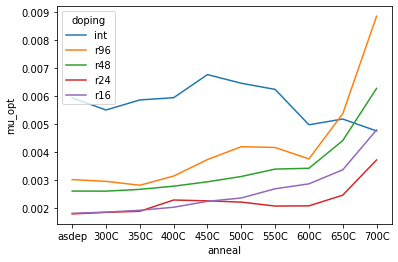

In [17]:
if __name__ == '__main__':
   # from matplotlib import pyplot as plt
    import seaborn as sns
    fig, ax = plt.subplots()
    sns.lineplot(
        x = 'anneal',
        y = 'mu_H',
        hue = 'doping',
        #style = 'cap',
        data = df[df.capping == 'capo'],
        )
    sns.lineplot(
        x = 'anneal',
        y = 'mu_opt',
        hue = 'doping',
        #hue = 'anneal',
        data = df[df.capping == 'cap'],
    )

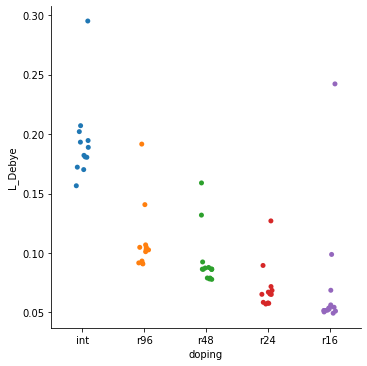

In [9]:
if __name__ == '__main__':
    import seaborn as sns
    sns.catplot(
        x = 'doping',
        y = 'L_Debye',
        data = df
    )

In [12]:
df.mu_opt.describe()

count    68.000000
mean      0.003673
std       0.001637
min       0.001780
25%       0.002290
50%       0.003062
75%       0.004827
max       0.008841
Name: mu_opt, dtype: float64